# Tonga Eruption Time

This is a quick check to see if there is any magnetic disturbance at the time of the Tonga Volcano eruption on the evening of January 14, 2022 7:14PM (AKST).

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


df = pd.read_csv('magtest_20220118.txt', parse_dates=[0], header=None, skiprows=3)
df.columns = ['LocalTime', 'F', 'X', 'Y', 'Z']

#save only the tail

#df = df.tail(7000)
#df = df.head(3500)
df = df[(df['LocalTime'] > '2022-01-14 12:00') & (df['LocalTime'] < '2022-01-15 06:00')]
print(df)

df.loc[:,'F_mean'] = df['F'].rolling(window=100, center=True).mean()
#observatory SIT = Sitka,  BRW = Barrow,  CMO = Fairbanks
obs = 'SIT'
timeoffset = 9   #AKST time zone


                 LocalTime            F     X    Y    Z
201935 2022-01-14 12:00:06  2571.693217  2439  786  217
201936 2022-01-14 12:00:17  2571.976089  2444  774  207
201937 2022-01-14 12:00:27  2571.303560  2439  785  216
201938 2022-01-14 12:00:37  2572.152600  2443  778  206
201939 2022-01-14 12:00:47  2571.679801  2441  780  216
...                    ...          ...   ...  ...  ...
208372 2022-01-15 05:59:14  2564.213720  2434  780  206
208373 2022-01-15 05:59:24  2567.236257  2435  786  209
208374 2022-01-15 05:59:34  2565.534252  2434  783  211
208375 2022-01-15 05:59:44  2565.127872  2434  783  206
208376 2022-01-15 05:59:54  2561.698070  2430  786  199

[6442 rows x 5 columns]


The data at the observatory is on GMT time and Alaska is currently 9 hours behind. As such, I have to adjust the observatory timestamp to the local time stamp.

In [46]:
#Set the start and end for the data to get from the USGS observatory. 
starttime = datetime.datetime.strftime(df['LocalTime'].min() + 
                              datetime.timedelta(hours=timeoffset), 
                              '%Y-%m-%dT%H:%M:%S') 
endtime =  datetime.datetime.strftime(df['LocalTime'].max() + 
                              datetime.timedelta(hours=timeoffset),
                              '%Y-%m-%dT%H:%M:%S')

Here I am using the USGS API to get data via HTTP request, and read it directly into a pandas dataframe. I manually set the columns and skip the header info. Then I create a local time stamp and perform a soft merge (because time stamps in their data might not match mine to the second) in order to join the data to the nearest second.

I have included a string variable for the observatory so that I can easily go back and see how my data compares with Fairbanks or Barrow as well.

In [47]:
def get_obs_data(obs, starttime, endtime, timeoffset, df):
    
    csvstring = f"https://geomag.usgs.gov/ws/data/?id={obs}&elements=" \
                f"H,D,Z,F&starttime={starttime}&endtime={endtime}"
    df_obs = pd.read_csv(csvstring, skiprows=21, delim_whitespace=True, 
                        parse_dates=[[0,1]], header=None, na_values='99999.00')
    df_obs.columns = ['GMTTime', 
                    'DOY', 
                    f'{obs}H', 
                    f'{obs}D', 
                    f'{obs}Z', 
                    f'{obs}F']

    df_obs['LocalTime'] = df_obs['GMTTime'] - datetime.timedelta(hours=timeoffset)
    dfresult = pd.merge_asof(df, df_obs, on='LocalTime')

    #Calculate a rolling correlation to see how well my data matches up with USGS data.
    dfresult.loc[:,f'{obs}F'] = dfresult[f'{obs}F'].fillna(method='bfill')
    dfresult['Corr'] = dfresult['F_mean'].rolling(3).corr(dfresult[f'{obs}F'])
    return dfresult

In [48]:
dfresult = get_obs_data(obs, starttime, endtime, timeoffset, df)

In order to see both curves clearly on the same plot, I am applying a "gain" and an offset to my data.

In [49]:
#Set a gain an calculate offset to apply to *match* with USGS data
gain = 4
offset = dfresult[f'{obs}F'].mean() - gain*dfresult['F_mean'].mean()

Text(0.5, 1.0, 'Geomagnetic Data - Total Field (F)')

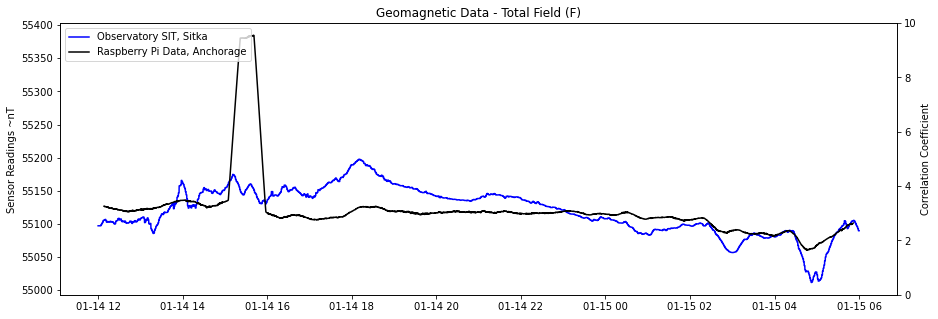

In [51]:
#Plot stuff
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime

def draw_date_patch(ax, startTime, endTime, y0, height):
    startTime = datetime.strptime(startTime, '%Y-%m-%d %H:%M')
    endTime = datetime.strptime(endTime, '%Y-%m-%d %H:%M')
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start
    rect = Rectangle((start, y0), width, height, color='yellow')
    ax.add_patch(rect)  
  
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = plt.subplots()
ax.plot(dfresult['LocalTime'], dfresult[f'{obs}F'], label=f'Observatory {obs}, Sitka', color='blue')
ax.plot(dfresult['LocalTime'], dfresult['F_mean']*gain + offset, label='Raspberry Pi Data, Anchorage', color='black')
#ax.plot(dfresult['LocalTime'], dfresult['F']*gain + offset, label='RM3100 (my data)', color='black')
plt.ylabel('Sensor Readings ~nT')
plt.legend(loc='upper left')


ax2 = ax.twinx()
#ax2.plot(dfresult['LocalTime'], dfresult['Corr'], color='purple', label='Corr')
ax2.set_ylim(0,10)

plt.ylabel('Correlation Coefficient')
plt.xlabel('Time (AKST)')
plt.title('Geomagnetic Data - Total Field (F)')
#plt.legend(loc='upper right')